In [1]:
import pandas as pd
import sklearn
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
%matplotlib inline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [2]:
os.listdir('./data')

['gender_submission.csv', 'test.csv', 'train.csv']

In [3]:
df_test = pd.read_csv('./data/test.csv')
df_train = pd.read_csv('./data/train.csv')
df_submission = pd.read_csv('./data/gender_submission.csv')

In [4]:
y_train_val = df_train.Survived

In [5]:
def transform(df,option):
    assert option in ["test","train"] , "Option must be test or train"
    df = df.set_index('PassengerId')
    cond = df.Fare.isnull()
    sub_value = df.Fare.mean()
    df.Fare = np.where(cond, sub_value, df.Fare)
    ticket_p = df.groupby('Ticket', as_index=False).agg({'Name': 'count'}).rename(columns={'Name':'t_count'}).sort_values('t_count', ascending=False)
    d = dict()
    for i, row in ticket_p.iterrows():
        d[row.Ticket] = row.t_count
    df_merge = df.copy()
    df_merge['t_count'] = df_merge.Ticket.apply(lambda x: d[x])
    df_merge['Fare_per_person'] = df_merge.Fare/df_merge.t_count
    cond = df_merge.Age.isnull()
    sub_value = df_merge.Age.mean()
    df_merge.Age = np.where(cond, sub_value, df_merge.Age)
    cond = (df_merge.Sex == 'female')
    sub_value = 1
    df_merge.Sex = np.where(cond, sub_value, 0)
    cond = df_merge.Embarked.isnull()
    sub_value = 'S'
    df_merge.Embarked = np.where(cond, 'S', df_merge.Embarked)
    df_merge = df_merge.drop(['Name', 'Ticket', 'Cabin'], axis=1)
    df_merge.isnull().sum()
    ohe = OneHotEncoder()
    X_cat = ohe.fit_transform(df_merge.Embarked.values.reshape(-1,1)).toarray()
    if option=="train":
        X_short = df_merge.drop(['Survived','Embarked'], axis=1).values
    else:
        X_short = df_merge.drop(['Embarked'], axis=1).values
    X = np.hstack([X_cat, X_short])
    return X

In [6]:
X_train_val=transform(df_train, "train")

In [7]:
X_test=transform(df_test,"test")

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [9]:
X_train.shape, X_val.shape

((712, 11), (179, 11))

In [10]:
lr=LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)
y_pred_val=lr.predict(X_val)
acc_val=accuracy_score(y_val,y_pred_val)
acc_val

0.8156424581005587

In [11]:
C_grid=np.logspace(-4,9,9)
C_grid

array([1.00000000e-04, 4.21696503e-03, 1.77827941e-01, 7.49894209e+00,
       3.16227766e+02, 1.33352143e+04, 5.62341325e+05, 2.37137371e+07,
       1.00000000e+09])

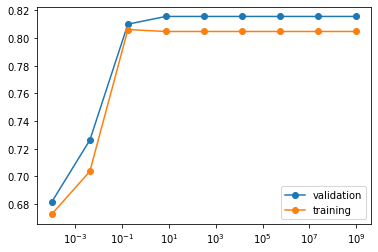

In [12]:
acc_vals=[]
acc_trains=[]
for c in C_grid:
    lr1=LogisticRegression(C=c,max_iter=500)
    lr1.fit(X_train, y_train)
    y_pred_val=lr1.predict(X_val)
    y_pred_train=lr1.predict(X_train)
    acc_train=accuracy_score(y_train,y_pred_train)
    acc_val=accuracy_score(y_val,y_pred_val)
    acc_vals.append(acc_val)
    acc_trains.append(acc_train)

plt.plot(C_grid,acc_vals,'-o', label='validation')
plt.xscale('log')
plt.plot(C_grid,acc_trains,'-o', label='training')
plt.legend()



In [13]:
acc_vals

[0.6815642458100558,
 0.7262569832402235,
 0.8100558659217877,
 0.8156424581005587,
 0.8156424581005587,
 0.8156424581005587,
 0.8156424581005587,
 0.8156424581005587,
 0.8156424581005587]

In [14]:
a=np.argmax(acc_vals)
C_best=C_grid[a]

In [15]:
lr1=LogisticRegression(C=C_best,max_iter=500)
lr1.fit(X_train, y_train)
y_pred_test=lr1.predict(X_test)
y_pred_test.shape

(418,)

In [16]:
df_submission['Survived']=y_pred_test

In [17]:
df_submission.to_csv('submission.csv', index=False)

In [18]:
"HW:Write a code that will manually split the X_train_val and y_train_val into five folds"
"Fold: in each fold 80% training and 20% validation"
"Each sample has to be used for validation once and train model for each fold and check accuracy"

'Each sample has to be used for validation once and train model for each fold and check accuracy'

In [19]:
def split_manual(X,y,num_folds):
    n_perfold=int(len(X)/num_folds)
    acc_vals=[]
    for i in range(num_folds):
        X_val_fold=X[n_perfold*i:n_perfold+n_perfold*i]
        y_val_fold=y[n_perfold*i:n_perfold+n_perfold*i]
        X_train_fold=np.concatenate((X[0:n_perfold*i],X[n_perfold+n_perfold*i:]),axis=0)
        y_train_fold=np.concatenate((y[0:n_perfold*i],y[n_perfold+n_perfold*i:]),axis=0)
        print("{} {} {} {}".format(X_val_fold.shape, y_val_fold.shape,X_train_fold.shape,  y_train_fold.shape ))
        lr1=LogisticRegression(C=C_best,max_iter=500)
        lr1.fit(X_train_fold, y_train_fold)
        y_pred_val=lr1.predict(X_val_fold)
        acc_val=accuracy_score(y_val_fold,y_pred_val)
        acc_vals.append(acc_val)
    return (acc_vals)

In [20]:
X_train.shape

(712, 11)

In [21]:
split_manual(X_train,y_train,5)

(142, 11) (142,) (570, 11) (570,)
(142, 11) (142,) (570, 11) (570,)
(142, 11) (142,) (570, 11) (570,)


C:\Users\gergo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(142, 11) (142,) (570, 11) (570,)
(142, 11) (142,) (570, 11) (570,)


[0.8169014084507042,
 0.8098591549295775,
 0.8098591549295775,
 0.7535211267605634,
 0.8169014084507042]

In [22]:
"HW: Read about how sklearn does cross validation and how the function works and implement it to get the list with one line of code"

'HW: Read about how sklearn does cross validation and how the function works and implement it to get the list with one line of code'

In [23]:
lr1=LogisticRegression(C=C_best,max_iter=500)
cross_val_score(lr1, X_train_val,y_train_val)

C:\Users\gergo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\gergo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

array([0.78212291, 0.78089888, 0.78089888, 0.76966292, 0.8258427 ])

In [24]:
"HW2: Come up with a way that undivisible samples can be split into uneven folds and still only use the samples only once for validation"

'HW2: Come up with a way that undivisible samples can be split into uneven folds and still only use the samples only once for validation'

In [25]:
def split_manual(X,y,num_folds):
    n_perfold=int(len(X)/num_folds)
    remain=len(X)%num_folds
    acc_vals=[]
    g=0
    for i in range(num_folds):
        X_val_fold=X[n_perfold*i+g:n_perfold+n_perfold*i+1+g]
        y_val_fold=y[n_perfold*i+g:n_perfold+n_perfold*i+1+g]
        X_train_fold=np.concatenate((X[0:n_perfold*i+g],X[n_perfold+g+n_perfold*i:]),axis=0)
        y_train_fold=np.concatenate((y[0:n_perfold*i+g],y[n_perfold+g+n_perfold*i:]),axis=0)
        g+=1
        print("{} {} {} {}".format(X_val_fold.shape, y_val_fold.shape,X_train_fold.shape,  y_train_fold.shape ))
        lr1=LogisticRegression(C=C_best,max_iter=500)
        lr1.fit(X_train_fold, y_train_fold)
        y_pred_val=lr1.predict(X_val_fold)
        acc_val=accuracy_score(y_val_fold,y_pred_val)
        acc_vals.append(acc_val)
    return (acc_vals)
print(split_manual(X_train,y_train,5))

(143, 11) (143,) (570, 11) (570,)
(143, 11) (143,) (570, 11) (570,)
(143, 11) (143,) (570, 11) (570,)


C:\Users\gergo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(143, 11) (143,) (570, 11) (570,)
(140, 11) (140,) (572, 11) (572,)
[0.8111888111888111, 0.8251748251748252, 0.8041958041958042, 0.7482517482517482, 0.8]


In [26]:
"Ex: 11 samples and 3 folds"

'Ex: 11 samples and 3 folds'

In [27]:
"Ex: 109 samples and 10 folds"

'Ex: 109 samples and 10 folds'

In [53]:
dt=DecisionTreeClassifier(max_depth=10,min_samples_split=20)
np.mean(cross_val_score(dt, X_train_val,y_train_val))

0.8148703785073128

In [52]:
def DTC(a,b):
    best_depth=0
    best_split=0
    best_cv=0
    for i in range(5,15,1):
        for g in range(15,25,1):
            dt=DecisionTreeClassifier(max_depth=i,min_samples_split=g)
            cv_score=cross_val_score(dt, X_train_val,y_train_val).mean()
            print(i,g,cv_score)
            if(cv_score>best_cv):
                best_cv=cv_score
                best_depth=i
                best_split=g
    return best_depth,best_split
print(DTC(30,30))

5 15 0.7968614650681063
5 16 0.7957567007720796
5 17 0.79686774213797
5 18 0.79686774213797
5 19 0.8002385286548239
5 20 0.8002385286548239
5 21 0.8002385286548239
5 22 0.797991337643588
5 23 0.7912497646098802
5 24 0.7912497646098802
6 15 0.8002259745150964
6 16 0.7968802962776975
6 17 0.80023225158496
6 18 0.7957567007720796
6 19 0.8002448057246877
6 20 0.7991274872889336
6 21 0.7991274872889336
6 22 0.7968802962776975
6 23 0.7901387232439896
6 24 0.7890151277383717
7 15 0.8114619295712762
7 16 0.8047454648170234
7 17 0.8069801016885318
7 18 0.8047454648170234
7 19 0.8081099742640137
7 20 0.8092335697696316
7 21 0.8092335697696316
7 22 0.8092335697696316
7 23 0.8024919967359236
7 24 0.8024982738057874
8 15 0.8148452702278576
8 16 0.8069989328981233
8 17 0.8069926558282594
8 18 0.807005209967987
8 19 0.8137279517921036
8 20 0.8126106333563493
8 21 0.8126106333563493
8 22 0.8103634423451134
8 23 0.8058690603226415
8 24 0.8036218693114054
9 15 0.8137342288619672
9 16 0.8070114870378507
